# Neural Networks & Deep Learning
在这一节中，我们将构建一个三层的神经网络来处理手写数字识别问题，之后我们将运用AdaGrad、RMSprop、Momentum、Nesterov Momentum和Adam优化算法来加速梯度下降的过程，首先我们先来实现一个简单的神经网络。 

## 1. 导入所需的Python库

In [1]:
import os
import struct
import numpy as np
import matplotlib.pyplot as plt

from utils import *

## 2. 加载数据并可视化
先介绍一下在这个实验中所用到的数据库MNIST，MNIST数据集是一个手写体数据集，其中每个手写数字是一张28×28的灰度图片，图片的标记为一个0-9表示的数字。  MNIST数据集一共有60000张图片用来作为训练集，10000张图片来作为测试集。  
我们知道一张灰度图片一般是二维的，但是神经网络中的全连接层的输入是一个一维的向量。所以我们需要将一张二维的灰度图片“压扁”成一个一维的向量，具体如下图所示：
![2d_to_1d](./images/2d_to_1d.jpg)
因此每一个样本都是一个784维的向量。 

在处理多分类任务时，我们可以使用softmax来进行处理，这里的手写数字识别任务就是一个多分类任务，共包含有10类，分别用数字0-9表示，而在softmax中，每一类可以表示为一个向量，所以我们需要将类对应的符号标记转化成一个向量表示，这就是one-hot向量，比如，在手写数字识别中，数字0和1对应的one-hot向量分别为： 
$$one-hot(0)=\begin{bmatrix}1 \\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix},one-hot(1)=\begin{bmatrix}0 \\ 1\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix}$$ 
在训练集中，我们需要把样本的标记$Y$转化为one-hot向量。  
另外值得注意的一点，在之前的实验中数据的第1个维度一般都是数据样本的索引，在这次实验中，为了保持代码与公式尽量形式一致，我们用第2个维度来表示数据的索引。因此，训练集的shape是$(784, 60000)$.

In [2]:
#加载训练集或测试集
path = './MNIST Data'    #数据集文件所在目录
X_train, Y_train = load_mnist(path)    #加载训练集样本X_train、Y_train
X_test, Y_test = load_mnist(path, kind='t10k')    #加载测试集样本X_test、Y_test
# 转换成one_hot向量
Y_train = np.eye(10)[Y_train].T
X_train = X_train.T
X_test = X_test.T
print('The shape of X_train is:',X_train.shape)
print('The shape of Y_train is:',Y_train.shape)
print('The shape of X_test is:',X_test.shape)
print('The shape of Y_test is:',Y_test.shape)

The shape of X_train is: (784, 60000)
The shape of Y_train is: (10, 60000)
The shape of X_test is: (784, 10000)
The shape of Y_test is: (10000,)


下面在训练集中找几个图片看一下。

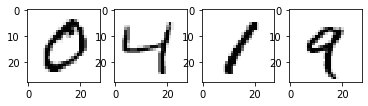

one hot 标签： [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
对应的实际标签： 0 4 1 9


In [3]:
fig = plt.figure()

ax1 = fig.add_subplot(141)
ax1.imshow(X_train[:,1].reshape(28, 28), cmap='Greys')
ax2 = fig.add_subplot(142)
ax2.imshow(X_train[:,2].reshape(28,28), cmap='Greys')
ax3 = fig.add_subplot(143)
ax3.imshow(X_train[:,3].reshape(28,28), cmap='Greys')
ax4 = fig.add_subplot(144)
ax4.imshow(X_train[:,4].reshape(28,28), cmap='Greys')
plt.show()
print('one hot 标签：',Y_train[:,1],Y_train[:,2],Y_train[:,3],Y_train[:,4])
print('对应的实际标签：',np.argmax(Y_train[:,1]),np.argmax(Y_train[:,2]),np.argmax(Y_train[:,3]),np.argmax(Y_train[:,4]))

## 3. 全连接神经网络

接下来，我们来搭建一个三层全连接神经网络。网络结构如下图所示：
![network_architecture](./images/network_architecture.jpg)

对公式所用符号的说明：  
一般算神经网络层数不算输入层，所以上图只有3层。用右上角的方括号表示相应的层，所有第1层的权重$W$为$W^{[1]}$，第1层的偏置项$b$为$b^{[1]}$(图中未标出)，第1层的激活值$A$为$A^{[1]}$。  
为了方便，我们将$\frac{\partial L}{\partial W^{[1]}}$简写为$dW^{[1]}$,将$\frac{\partial L}{\partial b^{[1]}}$简写为$db^{[1]}$.  
用右下标如$b_i$来表示变量的第$i$个分量，例如，$b^{[3]}_4$表示第3层的偏置项的第4个分量。


### 3.1 初始化网络参数

我们规定第1层的神经元个数为300，第二层个数为300，最后一层为10.输入向量$X$的维度为784，那么整个网络对应的参数也就可以确定了。  
$W^{[1]}$的shape为$(300,784)$，$b^{[1]}$的shape为$(300,1)$  
$W^{[2]}$的shape为$(300,300)$，$b^{[2]}$的shape为$(300,1)$  
$W^{[3]}$的shape为$(10,300)$，$b^{[3]}$的shape为$(10,1)$  
这里使用随机正态分布再乘上比例因子0.01来初始化$W$， 对$b$都初始化为0.  
**Hint**: 使用`np.random.randn()`,`np.zeros()`  
**任务1**: 初始化网络参数  


In [4]:
def initialize_parameters():
    """
    :return: parameters : python dictionary containing your parameters W1, b1, W2 , b2, W3 and b3
    """
    np.random.seed(1)
    
    ### START CODE HERE ### 
    
    W1 = np.random.randn(300, 784) * 0.01
    b1 = np.zeros(300).reshape(300, 1)
    W2 = np.random.randn(300, 300) * 0.01
    b2 = np.zeros(300).reshape(300, 1)
    W3 = np.random.randn(10, 300) * 0.01
    b3 = np.zeros(10).reshape(10, 1)
    
    ### START CODE HERE ### 
    
    parameters = dict({
        'W1':W1,
        'b1':b1,
        'W2':W2,
        'b2':b2,
        'W3':W3,
        'b3':b3
    })
    return parameters

In [5]:
#测试一下
parameters_test = initialize_parameters()
print('shape of W1 and b1',parameters_test['W1'].shape, parameters_test['b1'].shape)
print('shape of W2 and b2',parameters_test['W2'].shape, parameters_test['b2'].shape)
print('shape of W3 and b3',parameters_test['W3'].shape, parameters_test['b3'].shape)

shape of W1 and b1 (300, 784) (300, 1)
shape of W2 and b2 (300, 300) (300, 1)
shape of W3 and b3 (10, 300) (10, 1)


### 3.2 前向传播

下面回顾下前向传播的公式  
$$Z^{[1]}=W^{[1]}X+b^{[1]}$$
$$A^{[1]}=g^{[1]}(Z^{[1]})$$
$$Z^{[2]}=W^{[2]}A^{[1]}+b^{[2]}$$
$$A^{[2]}=g^{[2]}(Z^{[2]})$$
$$Z^{[3]}=W^{[3]}A^{[2]}+b^{[3]}$$
$$A^{[3]}=g^{[3]}(Z^{[3]})$$  
其中，$g^{[i]}$表示第$i$层的激活函数，这里在第1层和第2层都使用$tanh$函数，第3层使用$softmax$用来进行多分类。  
$softmax$函数的具体公式为
$$softmax(x_i)=\frac{e^{x_i}}{\sum_{j=1}^{C}{e^{x_j}}}$$ 
$x_i$表示为向量$x$的第$i$个分量。  
$softmax$函数这里直接给出，在实现的时候会减去一个最大值，防止指数运算结果太大，结果都是一样的。  
**Hint**:$tanh$函数可用`np.tanh()`  
**任务2**：完成神经网络前向传播  

In [6]:
def softmax(x):
    """
    :param x:
    :return:
    """
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis=0)  # only difference

In [7]:
def forward_propagation(X, parameters):
    """
    :param X: The input of network
    :param parameters: python dictionary containing your parameters W1, b1, W2 , b2, W3 and b3
    :return: A3, cache 
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### 
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = np.tanh(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = softmax(Z3)
    
    ### START CODE HERE ### 
    cache = {
        'Z1':Z1,
        'A1':A1,
        'Z2':Z2,
        'A2':A2,
        'Z3':Z3,
        'A3':A3   
    }
    return A3, cache    

In [8]:
#测试一下
X_1 = X_train[:,:4]
parameters_test = initialize_parameters()
A3, cache  = forward_propagation(X_1, parameters_test)
print(A3[:,1]) # 应该有10个数

[0.09671429 0.09951618 0.09903519 0.10044551 0.10144064 0.09887662
 0.10203982 0.10316373 0.10284349 0.09592453]


### 3.3 计算Loss  

在softmax中，我们一般使用的损失函数为交叉熵函数(这里的$\hat{y}$就是上面前向传播最后的输出$A^{[3]}$)：  
$$L(\hat{y},y)=-\sum_{j=1}^{C}{y_jlog\hat{y_j}}$$  
其中，$C$是类别的数量，在本次实验中即为10.  
成本函数为：  
$$J(W^{[1]},b^{[1]},...)=\frac{1}{m}\sum_{i=1}^{m}{L(\hat{y}^{(i)},y^{(i)})}$$  
这里$m$是mini-batch的大小。因为训练集有60000个，我们不能直接把$(784,60000)$大小的输入直接放入神经网络计算。因此，每次就选择一部分来进行前向传播，所以输入的大小是$(784,m)$，本次实验默认$m=128$.也就是输入$X$的shape为$(784,128)$  
**Hint**:  
(1) 没必要对上面第一个式子每个分量求和，它的向量化表示是$L(\hat{Y},Y)=-Y\log \hat{Y}$  
(2) `np.sum(A)`第二个参数axis不写,就是对整个A求和  
(3) 最后的Loss是个标量  
**任务3**：计算Loss

In [9]:
#计算成本函数
def compute_cost(A3, Y):
    """
    :param A3: The output of the second activation
    :param Y: the labels of examples
    :param parameters: python dictionary containing your parameters W1, b1, W2, b2, W3 and b3
    :return: cost -- cross-entropy cost
    """
    m = Y.shape[1]  #样本数量

    #计算交叉熵损失
    ### START CODE HERE ### 
#     print(Y * np.log(A3))
    cost = - np.sum(Y * np.log(A3)) / m
    
    ### END CODE HERE ###

    cost = np.squeeze(cost)  # makes sure cost is the dimension we expect.
    return cost

In [10]:
Y_1 = Y_train[:, :4]
print(compute_cost(A3, Y_1))

2.326457203114146


### 3.4 反向传播

反向传播用到的主要是链式求导法则，我们用dX表示损失Loss对于X的导数，这里直接给出最终的求导结果：$$\begin{align}
& dZ^{[3]}=A^{[3]}-Y  \\
& dW^{[3]}=\frac{1}{m}dZ^{[3]}A^{[2]T} \\
& db^{[3]}=\frac{1}{m}np.sum(dZ^{[3]},axis=1, keepdims=True) \\
& dA^{[2]}= W^{[3]^T}dZ^{[3]}\\
& dZ^{[2]}= dA^{[2]} * g^{[2]'}(Z^{[2]}) \\
& dW^{[2]}=\frac{1}{m}dZ^{[2]}A^{[1]T} \\
& db^{[2]}=\frac{1}{m}np.sum(dZ^{[2]},axis=1, keepdims=True) \\
\end{align}$$
至于$dW^{[1]}、db^{[1]}$则需要同学们自己求解  
**Hint**：  
(1)你可能需要用到`np.dot()`、`np.sum()`、`np.multiply()`、`np.power()`  
(2)上式中的$*$表示element-wise乘法即`np.multiply()`，直接写在一起是点乘即`np.dot()`  
(3)$g^{[1]'}$和$g^{[2]'}$ 都是$tanh$函数，$tanh$的导数为$g^{[2]'}(x) = 1-tanh^2(x)$ 而$tanh(Z^{[2]})=g^{[2]}(Z^{[2]})=A^{[2]}$

**任务4**：完成反向传播函数

In [11]:
def backward_propagation(parameters, cache, X, Y):
    """
    :param parameters: python dictionary containing your parameters W1, b1, W2, b2, W3 and b3
    :param cache: storing the result computed before
    :param X: the input of network
    :param Y: the labels of examples
    :return: grads : python dictionary containing gradients of your parameters dW1, db1, dW2, db2, dW3 and db3
    """
    m = X.shape[1]
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    
    A1 = cache['A1']
    A2 = cache['A2']
    A3 = cache['A3']
    ### START CODE HERE ### 
    
    dZ3 = A3-Y
    dW3 = np.dot(dZ3,A2.T)/m
    db3 = np.sum(dZ3,axis=1,keepdims=True)/m
    dA2 = np.dot(W3.T,dZ3)

    dZ2 = np.multiply(dA2,1-np.power(A2,2))
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m
    dA1 =np.dot(W2.T,dZ2)#debug

    dZ1 = np.multiply(dA1,1-np.power(A1,2))
    dW1 = np.dot(dZ1,X.T)/m#debug is erro
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    
    ### END CODE HERE ###
    grads = {
        'dW3':dW3,
        'db3':db3,
        'dW2':dW2,
        'db2':db2,
        'dW1':dW1,
        'db1':db1
    }
    return grads


In [12]:
grads = backward_propagation(parameters_test, cache, X_1, Y_1)
print('shape of dW3',grads['dW3'].shape)
print('db3:',grads['db3'])

shape of dW3 (10, 300)
db3: [[-0.15275006]
 [-0.15050809]
 [ 0.09806063]
 [ 0.10197992]
 [-0.1523379 ]
 [-0.15023912]
 [ 0.10089512]
 [ 0.10358038]
 [ 0.10249888]
 [ 0.09882025]]


### 3.4 参数更新  
按照下列公式计算：$$\begin{align} & W=W-\alpha dW \\ & b=b-\alpha db\end{align}$$  
**任务5**：对网络参数进行更新

In [13]:
def update_parameters(parameters, grads, learning_rate=0.001):
    """
    :param parameters: python dictionary containing your parameters W1, b1, W2, b2, W3 and b3
    :param grads: python dictionary containing gradients of your parameters dW1, db1, dW2, db2, dW3 and db3
    :param learning_rate: learning rate
    :return: parameters : python dictionary containing your updated parameters W1, b1, W2, b2, W3 and b3
    """
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    dW3 = grads['dW3']
    db3 = grads['db3']
    
    ### START CODE HERE ### 
    
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    
    ### END CODE HERE ###
    parameters = {'W1': W1,
                  'b1': b1,
                  'W2': W2,
                  'b2': b2,
                  'W3': W3,
                  'b3': b3}
    return parameters

In [14]:
def predict(X, parameters):
    """
    :param X: input data of size (n_x, m)
    :param parameters: python dictionary containing your parameters
    :return: predictions -- vector of predictions of our model
    """
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    y_hat, cache = forward_propagation(X, parameters)
    predictions = np.argmax(y_hat, axis=0)

    return predictions

### 3.5 搭积木

前面描述损失函数的时候简单提了下mini-batch,我们之前学过的梯度下降法称为batch梯度下降法，在batch梯度下降法的一次迭代过程中，我们必须遍历整个训练数据集然后才能进行一次梯度下降，当数据集比较大的时候，这个过程会比较慢。为了加快梯度下降的速度，我们将数据集分块，每遍历一个数据块，都进行一次梯度下降，遍历完一次整个数据集称为一代(epoch).  
在此次实验中，我们将mini-batch的大小设为128。`random_mini_batches`函数返回的mini_batches是一个列表，列表的元素是一小块一小块的X、Y组成的数据块，除了最后一个batch，前面每个batch都包含128个样本。  
**任务6**：搭建整个网络模型

In [15]:
#定义整个模型
def nn_model(X, Y, num_iterations=1000, learning_rate=0.001, mini_batch_size = 128, 
             beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-7, optimization='GD'):
    """
    :param X: input data
    :param Y: the labels of X
    :param num_iterations: Number of iterations in gradient descent loop
    :param learning_rate: learning rate
    :param mini_batch_size: size of the mini-batches, integer
    :param beta1: parameter of momentum and adam
    :param beta2: parameter of rmsprop and adam
    :param epsilon: small constant
    :param optimization: choose optimization
    :return: parameters -- parameters learnt by the model. They can then be used to predict.
    """
    J_history = []
    cost = 0
    seed = 1
    t = 0
    test_accuracy = []
    
    # 初始化参数
    parameters = initialize_parameters()
    
    if optimization == 'GD':
        pass
    elif optimization == 'AdaGrad':
        grads_squared = initialize_grads_squared(parameters)
    elif optimization == 'RMSprop':
        grads_squared = initialize_grads_squared(parameters)
    elif optimization == 'Momentum':
        v = initialize_velocity(parameters)
    elif optimization == 'Nesterov':
        v = initialize_velocity(parameters)
    elif optimization == 'Adam':
        v, u = initialize_adam(parameters)

    # Loop (gradient descent)

    for i in range(0, num_iterations):
        seed = seed + 1
        minibatches = random_mini_batches(X, Y, mini_batch_size, seed)
    
        predictions = predict(X_test, parameters)
        p = np.where(predictions == Y_test.flatten())
        accuracy = len(p[0]) / Y_test.shape[0]
        test_accuracy.append(accuracy)
                   
        for j, minibatch in enumerate(minibatches):
            (minibatch_X, minibatch_Y) = minibatch
            
            ### START CODE HERE ###
            
            # Forward propagation. Inputs: "minibatch_X, parameters". Outputs: "A3, cache".
            A3, cache = forward_propagation(minibatch_X, parameters)

            # Cost function. Inputs: "A3, minibatch_Y". Outputs: "cost".
            cost = compute_cost(A3, minibatch_Y)

            # Backpropagation. Inputs: "parameters, cache, minibatch_X, minibatch_Y". Outputs: "grads".
            grads = backward_propagation(parameters, cache, minibatch_X, minibatch_Y)

            # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
            #没有使用任何优化
            if optimization == 'GD':
                parameters = update_parameters(parameters, grads, learning_rate=learning_rate)
                
            ### END CODE HERE ###
            
            #使用优化算法进行优化
            elif optimization == 'AdaGrad':
                parameters, grads_squared = update_parameters_with_adagrad(parameters, grads, grads_squared, learning_rate, epsilon)
            elif optimization == 'Momentum': 
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta1, learning_rate)
            elif optimization == 'Nesterov':
                parameters, v = update_parameters_with_nesterov_momentum(parameters, grads, v, beta1, learning_rate)
            elif optimization == 'RMSprop':
                parameters, grads_squared = update_parameters_with_rmsprop(parameters, grads, grads_squared, beta2, learning_rate, epsilon)
            elif optimization == 'Adam':
                t = t + 1
                parameters, v, u = update_parameters_with_adam(parameters, grads, v, u, t, beta1, beta2, learning_rate, epsilon)
            if j == 0:
                J_history.append(cost)
            if i % 10 == 0 and j == 0:
                print("Cost after iteration %i: %f   The accuracy of the model on test set is: %f" % (i, cost,test_accuracy[-1]))
            

    predictions = predict(X_test, parameters)
    p = np.where(predictions == Y_test.flatten())
    accuracy = len(p[0]) / Y_test.shape[0]
    test_accuracy.append(accuracy)
    plt.subplot(1,2,1)
    plt.plot(J_history)
    plt.ylabel('cost')
    plt.xlabel('epochs')
    plt.title("optimization = " + optimization)
    plt.subplot(1,2,2)
    plt.plot(test_accuracy)
    plt.ylabel('accuracy on test')
    plt.xlabel('epochs')
    plt.title("optimization = " + optimization)
    plt.show()

    return J_history, test_accuracy, parameters 

用普通梯度下降法训练模型(每次训练大概要用10分钟左右，为了节省时间，如果在10次迭代后在测试集精度没有达到0.85以上就可以停止了，下同)

In [ ]:
#开始训练模型并计算精度
J_history, test_accuracy, parameters = nn_model(X_train, Y_train, num_iterations=100, optimization='GD')
print('The accuracy of the model on test set is:', test_accuracy[-1])

Cost after iteration 0: 2.304131   The accuracy of the model on test set is: 0.095900
Cost after iteration 10: 0.388488   The accuracy of the model on test set is: 0.905600
Cost after iteration 20: 0.237525   The accuracy of the model on test set is: 0.928200
Cost after iteration 30: 0.153688   The accuracy of the model on test set is: 0.939100
Cost after iteration 40: 0.112875   The accuracy of the model on test set is: 0.944000
Cost after iteration 50: 0.114501   The accuracy of the model on test set is: 0.948100
Cost after iteration 60: 0.079502   The accuracy of the model on test set is: 0.949300
Cost after iteration 70: 0.129539   The accuracy of the model on test set is: 0.950800
Cost after iteration 80: 0.110828   The accuracy of the model on test set is: 0.951100
Cost after iteration 90: 0.127389   The accuracy of the model on test set is: 0.952100


## 4. 梯度下降优化算法

下面回顾几种上课讲过的优化算法，注意它们之间的差异与联系。


### 4.1 AdaGrad  

当$J(\theta)$收敛到最低值附近时，因为步长$\alpha$大小固定的原因，$J(\theta)$会在最低值附近徘徊，而不能到达最低值。因此，AdaGrad的想法是随着迭代次数的增加降低学习率$\alpha$，学习率$\alpha$衰减的方式是
$$
\alpha^t = \frac{\alpha}{\sqrt{t+1}}
$$
其中t表示第t次迭代。

如果梯度数值小，$J(\theta)$的移动步长小，$J(\theta)$在坡度平缓的区域内下降速度会变慢。AdaGrad使用均方根来加快$J(\theta)$在平缓区域的下降速度。均方根的表示为
$$
\sigma^t = \sqrt{\frac{1}{t+1} \sum_{i=0}^{t}(g^i)2}
$$
其中$g^i$表示历史的梯度值。AdaGrad 的更新参数公式是
$$
\begin{aligned}
\theta^{t+1} & := \theta^t - \frac{\alpha^t}{\sigma^t} g^t \\
& := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2}} g^t
\end{aligned}
$$
在坡度平缓的区域，均方根的数值小，梯度除以一个数值小的数会变大，从而加大了$J(\theta)$移动步长，也因此加快梯度下降速度。但是，AdaGrad的缺点是，随着迭代次数的增大，均方根会越来越大，梯度趋近于0，导致训练提前停止。为了防止分母为0，我们给分母加上一个小数值$\epsilon =10^{-7}$。
$$
\theta^{t+1} := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2} + \epsilon} g^t
$$

我们可以看到分母里会计算所有历史梯度值的平方和，所以在实现的时候不用保存所有的历史梯度值，只需要保存一个纪录所有历史梯度平方和的值即可。每个参数的历史梯度和初始值为0。  
**Hint** ：使用`np.zeros()`,`grads_squared`的shape与对应的参数相同   
**任务7**：初始化AdaGrad的历史梯度平方和  

In [104]:
def initialize_grads_squared(parameters):
    """
    :param parameters: python dictionary containing your parameters.
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    :return: grads_squared 
    """
    L = len(parameters) // 2 #神经网络的层数
    grads_squared = {}
    
    # Initialize grads_squared
    for l in range(L):
        ### START CODE HERE ###
        
        grads_squared["dW" + str(l+1)] = np.zeros(parameters['W' + str(l + 1)].shape)
        grads_squared["db" + str(l+1)] = np.zeros(parameters['b' + str(l + 1)].shape)
        
        ### END CODE HERE ###
        
    return grads_squared

In [105]:
parameters_test = initialize_parameters()
grads_squared = initialize_grads_squared(parameters_test)
print('shape of grads_squared dW1 ',grads_squared['dW1'].shape)
print('grads_squared db3: ',grads_squared['db3'])

shape of grads_squared dW1  (300, 784)
grads_squared db3:  [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


在分母的求和项是从$t=0$时的梯度一直到当前的梯度，所以算历史梯度平方和的要把当前的梯度平方先加进去。  
**任务8**：完成AdaGrad算法

In [110]:
def update_parameters_with_adagrad(parameters, grads, grads_squared, learning_rate=0.001, epsilon = 1e-7):
    """
    :param parameters: python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    :param grads: python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    :param grads_squared: python dictionary containing the current velocity:
                    grads_squared['dW' + str(l)] = ...
                    grads_squared['db' + str(l)] = ...
    :param learning_rate: the learning rate, scalar
    :param epsilon: epsilon, scalar
    :return: parameters， grads_squared 
    """
    L = len(parameters) // 2 # 神经网络的层数
    
    # Momentum update for each parameter
    for l in range(L):
        ### START CODE HERE ### 
        
        #计算历史梯度平方和
        grads_squared["dW" + str(l+1)] += grads["dW" + str(l+1)] ** 2
        grads_squared["db" + str(l+1)] += grads["db" + str(l+1)] ** 2     
        parameters["W" + str(l+1)] -=  learning_rate * grads["dW" + str(l+1)] / (np.sqrt(grads_squared["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -=  learning_rate * grads["db" + str(l+1)] / (np.sqrt(grads_squared["db" + str(l+1)]) + epsilon)
        
        ### END CODE HERE ###
        
    return parameters, grads_squared

Cost after iteration 0: 2.304131   The accuracy of the model on test set is: 0.095900
Cost after iteration 10: 0.109038   The accuracy of the model on test set is: 0.952200
Cost after iteration 20: 0.054122   The accuracy of the model on test set is: 0.956700
Cost after iteration 30: 0.040754   The accuracy of the model on test set is: 0.958200
Cost after iteration 40: 0.023364   The accuracy of the model on test set is: 0.960400
Cost after iteration 50: 0.028877   The accuracy of the model on test set is: 0.961200
Cost after iteration 60: 0.013662   The accuracy of the model on test set is: 0.962900
Cost after iteration 70: 0.049356   The accuracy of the model on test set is: 0.963400
Cost after iteration 80: 0.013314   The accuracy of the model on test set is: 0.964300
Cost after iteration 90: 0.015712   The accuracy of the model on test set is: 0.964800


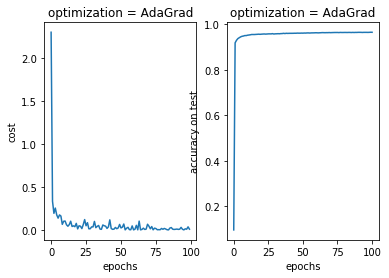

The accuracy of the model on test set is: 0.965


In [111]:
#开始训练模型并计算精度
J_history, test_accuracy, parameters = nn_model(X_train, Y_train, num_iterations=100, optimization='AdaGrad')
print('The accuracy of the model on test set is:', test_accuracy[-1])

### 4.2 RMSprop  

从AdaGrad算法的公式可看出，所有时刻的梯度都对当前的参数更新有影响。如果早先的梯度并不是一个正确的方向，那么这些糟糕的梯度还是会影响到当前的参数更新。因此，RMSprop相当于就是只记录当前时刻前的某一段历史梯度和而不是所有历史梯度和。  
RMSprop算法的公式如下：  
$$
 u^0 = 0 \\
 u^{t+1} = \rho u^t + (1-\rho) [\nabla J(\theta ^t)]^2 \\ 
 \theta^{t+1} = \theta^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}\nabla J(\theta ^t) 
$$
这里$\rho$是超参数，一般设为0.999，也不会调它。$\epsilon$是防止分母为0。另外值得注意的是，因为要整合这几个算法在一起，而Adam算法又融合了各种算法，所以，关于优化算法的超参数的命名与Adam里保持一致，公式里的$\rho$用下面参数`beta`代替。这些算法几乎都要保存一些变量，它们的初始化基本与AdaGrad初始化的方法一致，所以这部分初始化的代码就不重复了。  
**任务9**：完成RMSprop算法

In [120]:
def update_parameters_with_rmsprop(parameters, grads, grads_squared, beta=0.999, learning_rate=0.001, epsilon = 1e-7):
    """
    :param parameters: python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    :param grads: python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    :param grads_squared: python dictionary containing the current velocity:
                    grads_squared['dW' + str(l)] = ...
                    grads_squared['db' + str(l)] = ...
    :param beta: the RMSprop hyperparameter, scalar
    :param learning_rate: the learning rate, scalar
    :param epsilon: epsilon, scalar
    :return: parameters , grads_squared
    """
    L = len(parameters) // 2 # 神经网络的层数
    
    # Momentum update for each parameter
    for l in range(L):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        grads_squared["dW" + str(l+1)] = beta * grads_squared["dW" + str(l+1)] + (1 - beta) * grads["dW" + str(l + 1)] ** 2
        grads_squared["db" + str(l+1)] = beta * grads_squared["db" + str(l+1)] + (1 - beta) * grads["db" + str(l + 1)] ** 2
        
        parameters["W" + str(l+1)] -=  learning_rate * grads["dW" + str(l+1)] / (np.sqrt(grads_squared["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -=  learning_rate * grads["db" + str(l+1)] / (np.sqrt(grads_squared["db" + str(l+1)]) + epsilon)
        
        ### END CODE HERE ###
        
    return parameters, grads_squared

Cost after iteration 0: 2.304131   The accuracy of the model on test set is: 0.095900
Cost after iteration 10: 0.229314   The accuracy of the model on test set is: 0.941700
Cost after iteration 20: 0.167422   The accuracy of the model on test set is: 0.940300
Cost after iteration 30: 0.148953   The accuracy of the model on test set is: 0.950700
Cost after iteration 40: 0.107600   The accuracy of the model on test set is: 0.947000
Cost after iteration 50: 0.128049   The accuracy of the model on test set is: 0.952600
Cost after iteration 60: 0.127647   The accuracy of the model on test set is: 0.952500
Cost after iteration 70: 0.129203   The accuracy of the model on test set is: 0.955200
Cost after iteration 80: 0.192168   The accuracy of the model on test set is: 0.953600
Cost after iteration 90: 0.079178   The accuracy of the model on test set is: 0.957800


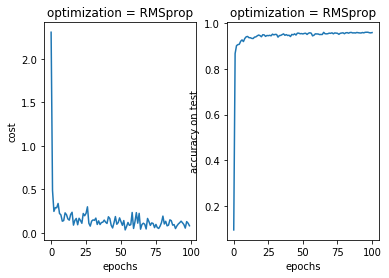

The accuracy of the model on test set is: 0.9585


In [121]:
#开始训练模型并计算精度
J_history, test_accuracy, parameters = nn_model(X_train, Y_train, num_iterations=100, optimization='RMSprop')
print('The accuracy of the model on test set is:', test_accuracy[-1])

### 4.3 Momentum

动量梯度下降（Gradient Descent with Momentum）基本思想就是计算梯度的指数加权平均数，并利用该指数加权平均数更新权重。具体过程为：
$$
v^0 = 0 \\
v^{t+1}  = \rho v^t +\alpha \nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$

这里的$\rho$一般取0.9。  
**任务10**：完成Momentum算法

In [122]:
def update_parameters_with_momentum(parameters, grads, v, beta=0.9, learning_rate=0.001):
    """
    :param parameters: python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    :param grads: python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    :param v: python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    :param beta: the momentum hyperparameter, scalar
    :param learning_rate: the learning rate, scalar
    :return: parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2 # 神经网络的层数
    
    # Momentum update for each parameter
    for l in range(L):
        ### START CODE HERE ### 
        
        #计算动量
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + learning_rate * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + learning_rate * grads["db" + str(l+1)]
        #更新参数
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - v["db" + str(l+1)]
        
        ### END CODE HERE ###
        
    return parameters, v

Cost after iteration 0: 2.304131   The accuracy of the model on test set is: 0.095900
Cost after iteration 10: 0.165310   The accuracy of the model on test set is: 0.951900
Cost after iteration 20: 0.194809   The accuracy of the model on test set is: 0.958200
Cost after iteration 30: 0.138793   The accuracy of the model on test set is: 0.956400
Cost after iteration 40: 0.070811   The accuracy of the model on test set is: 0.959300
Cost after iteration 50: 0.103725   The accuracy of the model on test set is: 0.954600
Cost after iteration 60: 0.114138   The accuracy of the model on test set is: 0.958800
Cost after iteration 70: 0.163700   The accuracy of the model on test set is: 0.961300
Cost after iteration 80: 0.126368   The accuracy of the model on test set is: 0.963700
Cost after iteration 90: 0.098714   The accuracy of the model on test set is: 0.962300


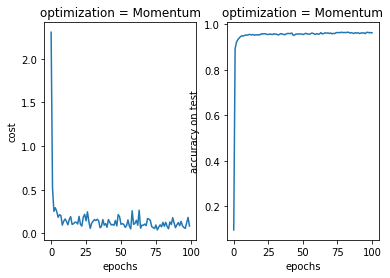

The accuracy of the model on test set is: 0.9621


In [123]:
#开始训练模型并计算精度
J_history, test_accuracy, parameters = nn_model(X_train, Y_train, num_iterations=100, optimization='Momentum')
print('The accuracy of the model on test set is:', test_accuracy[-1])

### 4.4 Nesterov Momentum 

Nesterov Momentum算法与Momentum不同的是在于，它会提前计算一个在速度作用后的梯度。具体算法如下：
$$
v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t - \rho v^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$
但是在实现的时候，我们是不会算一次$J(\theta ^t)$再算一次$\nabla J(\theta ^t - \rho v^t)$的。具体编程实现时上式等价于下式：
$$
 v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t) \\
 \theta^{t+1} = \theta ^t - \rho v^{t+1} - \alpha \nabla J(\theta ^t)
$$
这里的$\rho$一般取0.9。   
**任务11**:Nesterov Momentum算法

In [126]:
#nesterov momentum
def update_parameters_with_nesterov_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using nesterov_momentum
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- python dictionary containing the current velocity:
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- the learning rate, scalar

    Returns:
    parameters -- python dictionary containing your updated parameters
    v -- python dictionary containing your updated velocities

    '''
    VdW = beta * VdW + learning_rate * dW
    Vdb = beta * Vdb + learning_rate * db
    W = W - beta * VdW - learning_rate * dW
    b = b - beta * Vdb - learning_rate * db
    '''
    """

    L = len(parameters) // 2  # number of layers in the neural networks

    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        v["dW" + str(l + 1)] = beta * v["dW" + str(l + 1)] + learning_rate * grads["dW" + str(l + 1)]
        v["db" + str(l + 1)] = beta * v["db" + str(l + 1)] + learning_rate * grads["db" + str(l + 1)]
        # update parameters
        parameters["W" + str(l + 1)] -= (beta * v["dW" + str(l + 1)]  + learning_rate * grads["dW" + str(l + 1)])
        parameters["b" + str(l + 1)] -= (beta * v["db" + str(l + 1)]  + learning_rate * grads["db" + str(l + 1)])

    return parameters, v


Cost after iteration 0: 2.304131   The accuracy of the model on test set is: 0.095900
Cost after iteration 10: 0.158312   The accuracy of the model on test set is: 0.949300
Cost after iteration 20: 0.187960   The accuracy of the model on test set is: 0.954500
Cost after iteration 30: 0.082484   The accuracy of the model on test set is: 0.955500
Cost after iteration 40: 0.093893   The accuracy of the model on test set is: 0.955800
Cost after iteration 50: 0.078384   The accuracy of the model on test set is: 0.959200
Cost after iteration 60: 0.116723   The accuracy of the model on test set is: 0.961100
Cost after iteration 70: 0.156473   The accuracy of the model on test set is: 0.957200
Cost after iteration 80: 0.184114   The accuracy of the model on test set is: 0.956900
Cost after iteration 90: 0.144678   The accuracy of the model on test set is: 0.958300


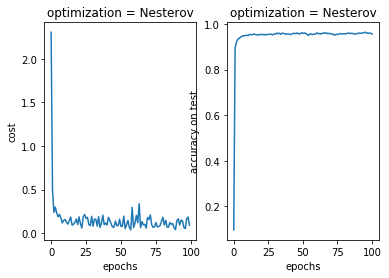

The accuracy of the model on test set is: 0.9559


In [127]:
#开始训练模型并计算精度
J_history, test_accuracy, parameters = nn_model(X_train, Y_train, num_iterations=100, optimization='Nesterov')
print('The accuracy of the model on test set is:', test_accuracy[-1])

### 4.5 Adam

Adam优化算法（Adaptive Moment Estimation）是将Momentum和RMSprop结合在一起的算法，具体过程如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}v^{t+1}
$$
从上式可以看到，在最开始更新时，$u^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
u^{t+1}_{corrected} = \frac{u^{t+1}}{1-\rho_2^t} \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0.  
**任务12**：完成Adam算法

In [132]:
#使用Adam更新参数
def update_parameters_with_adam(parameters, grads, v, u, t, beta1 = 0.9, 
                                beta2 = 0.999, learning_rate = 0.001, epsilon = 1e-7):
    """
    :param parameters: python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    :param grads: python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    :param v: Adam variable, moving average of the first gradient, python dictionary
    :param u: Adam variable, moving average of the squared gradient, python dictionary
    :param t: epoch number
    :param beta1: Exponential decay hyperparameter for the first moment estimates 
    :param beta2: Exponential decay hyperparameter for the second moment estimates 
    :param learning_rate: the learning rate, scalar.
    :param epsilon: hyperparameter preventing division by zero in Adam updates
    :return: parameters -- python dictionary containing your updated parameters 
    """
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    u_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ###
        
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]
        
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ###
        
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1 ** t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1 ** t)
        
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "u, grads, beta2". Output: "u".
        ### START CODE HERE ###
        
        u["dW" + str(l+1)] = beta2 * u["dW" + str(l+1)] + (1 - beta2) * grads["dW" + str(l+1)] ** 2
        u["db" + str(l+1)] = beta2 * u["db" + str(l+1)] + (1 - beta2) * grads["db" + str(l+1)] ** 2
        
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "u, beta2, t". Output: "u_corrected".
        ### START CODE HERE ###
        
        u_corrected["dW" + str(l+1)] = u["dW" + str(l+1)] / (1 - beta2 ** t)
        u_corrected["db" + str(l+1)] = u["db" + str(l+1)] / (1 - beta2 ** t)
        
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, u_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ###
        
        parameters["W" + str(l+1)] -= learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(u_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] -= learning_rate * v_corrected["db" + str(l+1)] / (np.sqrt(u_corrected["db" + str(l+1)]) + epsilon)
        
        ### END CODE HERE ###

    return parameters, v, u

Cost after iteration 0: 2.304131   The accuracy of the model on test set is: 0.095900
Cost after iteration 10: 0.196642   The accuracy of the model on test set is: 0.930400
Cost after iteration 20: 0.208819   The accuracy of the model on test set is: 0.940900
Cost after iteration 30: 0.119547   The accuracy of the model on test set is: 0.954000
Cost after iteration 40: 0.098315   The accuracy of the model on test set is: 0.956100
Cost after iteration 50: 0.117937   The accuracy of the model on test set is: 0.958300
Cost after iteration 60: 0.060521   The accuracy of the model on test set is: 0.953900
Cost after iteration 70: 0.122098   The accuracy of the model on test set is: 0.962400
Cost after iteration 80: 0.136229   The accuracy of the model on test set is: 0.958500
Cost after iteration 90: 0.060113   The accuracy of the model on test set is: 0.962900


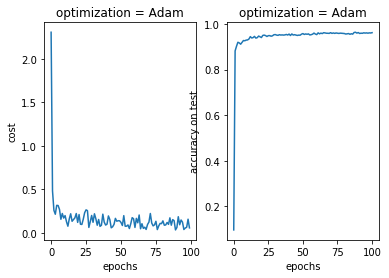

The accuracy of the model on test set is: 0.9623


In [133]:
#开始训练模型并计算精度
J_history, test_accuracy, parameters = nn_model(X_train, Y_train, num_iterations=100, optimization='Adam')
print('The accuracy of the model on test set is:', test_accuracy[-1])

## 5. 总结
本次实验完整搭建了一个三层的全连接网络，使用了各种梯度更新优化算法训练MNIST数据集。  
提交作业后，可以试试提升精确度到97%以上？